In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import cv2
import matplotlib.pyplot as plt
import os
import seaborn as sns
from PIL import Image
from tensorflow.keras import models
from scipy import misc
from os import listdir
from os.path import isfile, join
import numpy as np
from scipy import misc
from random import shuffle
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.applications import ResNet50, DenseNet121, Xception, EfficientNetB7
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense,GlobalAveragePooling2D,LSTM
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import KFold
from keras.preprocessing.image import ImageDataGenerator
import gc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.listdir('/content/drive/MyDrive/Datasets/COVID-19_Radiography_Dataset')
NORMAL=os.listdir('/content/drive/MyDrive/Datasets/COVID-19_Radiography_Dataset/Normal')
COVID=os.listdir('/content/drive/MyDrive/Datasets/COVID-19_Radiography_Dataset/COVID')
Viral=os.listdir('/content/drive/MyDrive/Datasets/COVID-19_Radiography_Dataset/Viral Pneumonia')


data=np.concatenate([NORMAL,COVID,Viral])
len(data)==len(COVID)+len(NORMAL)+len(Viral) 

True

In [ ]:
np.size(COVID)

3616

In [ ]:
np.size(NORMAL)

10192

## **Viral Pneumonia Images Before Augmentation**

In [ ]:
np.size(Viral)

1345

# **Viral Pneumonia Images after Augmentation**

In [ ]:
np.size(Viral)

4225

In [ ]:
target_x=np.full(len(NORMAL),0)
target_y=np.full(len(COVID),1)
target_z=np.full(len(Viral),2)
data_target=np.concatenate([target_x,target_y,target_z])
len(data_target)==len(target_x)+len(target_y)+len(target_z)

True

In [ ]:
X_data = []
for file in NORMAL:
    
    img = cv2.imread('/content/drive/MyDrive/Datasets/COVID-19_Radiography_Dataset/Normal/'+file)
    face = cv2.resize(img, (224, 224) )
    (b, g, r)=cv2.split(face) 
    img=cv2.merge([r,g,b])
   
    X_data.append(img)

In [ ]:
np.save('/content/drive/MyDrive/Datasets/COVID-19_Radiography_Dataset/Normal', X_data, allow_pickle=True, fix_imports=True)

In [ ]:
COVID_data=[]

In [ ]:
for file in COVID:
    
    img = cv2.imread('/content/drive/MyDrive/Datasets/COVID-19_Radiography_Dataset/COVID/'+file)
    face = cv2.resize(img, (224, 224) )
    (b, g, r)=cv2.split(face) 
    img=cv2.merge([r,g,b])
    COVID_data.append(img)
    X_data.append(img)
  
len(X_data)

13808

In [ ]:
V_data=[]

In [ ]:
X_data=[]
for file in Viral:
    
    img = cv2.imread('/content/drive/MyDrive/Datasets/COVID-19_Radiography_Dataset/Viral Pneumonia/'+file)
    face = cv2.resize(img, (224, 224) )
    (b, g, r)=cv2.split(face) 
    img=cv2.merge([r,g,b])
    V_data.append(img)
    X_data.append(img)
  
len(X_data)

4225

In [ ]:
np.save('/content/drive/MyDrive/Datasets/COVID-19_Radiography_Dataset/Viral Pneumonia', V_data, allow_pickle=True, fix_imports=True)

In [ ]:
N_data= np.load('/content/drive/MyDrive/Datasets/COVID-19_Radiography_Dataset/Normal.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

In [ ]:
C_data= np.load('/content/drive/MyDrive/Datasets/COVID-19_Radiography_Dataset/COVID.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

In [ ]:
V_data= np.load('/content/drive/MyDrive/Datasets/COVID-19_Radiography_Dataset/Viral Pneumonia.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

In [ ]:
X_data = np.concatenate([N_data,C_data,V_data])

In [ ]:
len(X_data)

18033

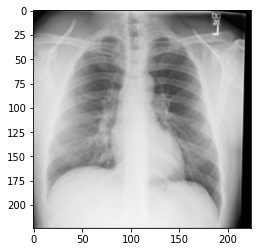

In [ ]:
# Visualizing Training data
plt.imshow(X_data[3004])


In [ ]:
len(X_data)==len(data_target)


True

In [ ]:
X = np.squeeze(X_data)

In [ ]:
X.shape

(18033, 224, 224, 3)

In [ ]:
# normalize data
X = X.astype('float16')
X /= 255

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
X_train, X_rem, y_train, y_rem = train_test_split(X,data_target, train_size=0.8)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)

test_size = 0.5
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)


In [ ]:
print(X_train.shape, X_test.shape,X_valid.shape, y_train.shape,y_valid.shape, y_test.shape)

(14426, 224, 224, 3) (1804, 224, 224, 3) (1803, 224, 224, 3) (14426,) (1803,) (1804,)


In [ ]:
N_data=C_data=V_data=X_data=X=[]

In [ ]:
IMAGE_SIZE = [224, 224]

In [ ]:

#from d2l import tensorflow as d2l

class Residual(tf.keras.Model):  
    """The Residual block of ResNet."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(num_channels, padding='same',
                                            kernel_size=3, strides=strides)
        self.conv2 = tf.keras.layers.Conv2D(num_channels, kernel_size=3,
                                            padding='same')
        self.conv3 = None
        if use_1x1conv:
            self.conv3 =  tf.keras.layers.Conv2D(num_channels, kernel_size=1,
                                                strides=strides)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()

    def call(self, X):
        Y = tf.keras.activations.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3 is not None:
            X = self.conv3(X)
        Y += X
        return tf.keras.activations.relu(Y)


In [ ]:
class ResnetBlock(tf.keras.layers.Layer):
    def __init__(self, num_channels, num_residuals, first_block=False,
                 **kwargs):
        super(ResnetBlock, self).__init__(**kwargs)
        self.residual_layers = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                self.residual_layers.append(
                    Residual(num_channels, use_1x1conv=True, strides=2))
            else:
                self.residual_layers.append(Residual(num_channels))

    def call(self, X):
        for layer in self.residual_layers.layers:
            X = layer(X)
        return X

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,Permute, TimeDistributed, Bidirectional,GRU
from keras.layers import LeakyReLU
from keras.optimizers import rmsprop_v2
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
hidden_unit = 32
kernel_size = 3
model = Sequential()
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same' , activation ='relu',input_shape = (224,224,3)))
model.add(BatchNormalization())

model.add(ResnetBlock(64, 2, first_block=True))
model.add(ResnetBlock(64, 2, first_block=True))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.25))

model.add(ResnetBlock(128, 2))
model.add(ResnetBlock(128, 2))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(ResnetBlock(256, 2))
model.add(ResnetBlock(256, 2))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(1,2), strides=(1,2)))
model.add(Dropout(0.25))

model.add(TimeDistributed(Flatten()))
model.add(Bidirectional(GRU(hidden_unit,return_sequences=True)))
model.add(Flatten())
model.add(Dense(256 , activation ='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(3, activation = "softmax"))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 64)     256       
 ormalization)                                                   
                                                                 
 resnet_block (ResnetBlock)  (None, 224, 224, 64)      148736    
                                                                 
 resnet_block_1 (ResnetBlock  (None, 224, 224, 64)     148736    
 )                                                               
                                                                 
 batch_normalization_9 (Batc  (None, 224, 224, 64)     256       
 hNormalization)                                                 
                                                        

In [ ]:
opt = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer=opt,
  metrics=['accuracy']
)

In [ ]:
file_path = os.path.join('/content/drive/MyDrive/Models', 'Threeclass_Residual-Bi-GRU_without_KFold(Updated_dataset)', 'ThreeCLass.h5')
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau

rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 10, verbose = 1, 
                                min_delta = 1e-4, min_lr = 1e-6, mode = 'min')
ckp = ModelCheckpoint(filepath= file_path,monitor = 'val_loss',
                      verbose = 1, save_best_only = True, mode = 'min', save_weights_only = True)

In [ ]:
fit_history = model.fit(X_train,
                        y_train,
                        batch_size = 8,
                        shuffle = True,
                        epochs = 50,
                        #initial_epoch=10,
                        validation_data = (X_valid,y_valid),
                        callbacks=[rlr,ckp])
        

Epoch 1/50
1804/1804 [==============================] - ETA: 0s - loss: 0.8100 - accuracy: 0.6729
Epoch 00001: val_loss improved from inf to 0.54974, saving model to /content/drive/MyDrive/Models/Threeclass_Residual-Bi-GRU_without_KFold(Updated_dataset)/ThreeCLass.h5
1804/1804 [==============================] - 295s 151ms/step - loss: 0.8100 - accuracy: 0.6729 - val_loss: 0.5497 - val_accuracy: 0.7820 - lr: 0.0010
Epoch 2/50
1804/1804 [==============================] - ETA: 0s - loss: 0.5577 - accuracy: 0.7763
Epoch 00002: val_loss improved from 0.54974 to 0.32903, saving model to /content/drive/MyDrive/Models/Threeclass_Residual-Bi-GRU_without_KFold(Updated_dataset)/ThreeCLass.h5
1804/1804 [==============================] - 268s 149ms/step - loss: 0.5577 - accuracy: 0.7763 - val_loss: 0.3290 - val_accuracy: 0.8674 - lr: 0.0010
Epoch 3/50
1804/1804 [==============================] - ETA: 0s - loss: 0.4721 - accuracy: 0.8121
Epoch 00003: val_loss did not improve from 0.32903
1804/1804 [

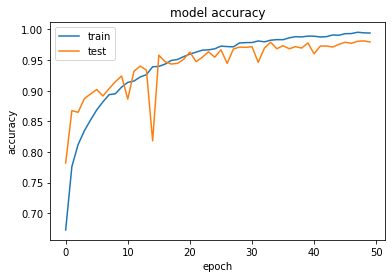

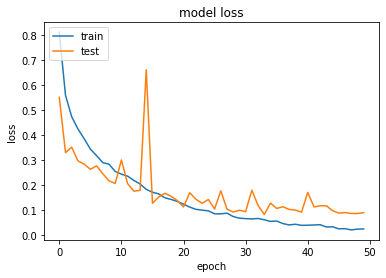

In [ ]:
# summarize history for accuracy
plt.plot(fit_history.history['accuracy'])
plt.plot(fit_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(fit_history.history['loss'])
plt.plot(fit_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from tensorflow.math import confusion_matrix
from sklearn.metrics import accuracy_score

#actual =  valid_data.labels
preds = np.argmax(model.predict(X_test), axis=1)
cfmx = confusion_matrix(y_test, preds)
acc = accuracy_score(y_test,preds)
print ('Test Accuracy:', acc )
print('Confusion matrix:', cfmx)

Test Accuracy: 0.9839246119733924
Confusion matrix: tf.Tensor(
[[976   6   2]
 [ 15 362   3]
 [  2   1 437]], shape=(3, 3), dtype=int32)


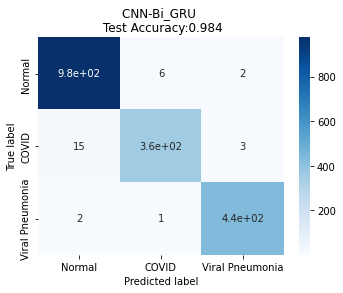

In [ ]:
from sklearn.svm import SVC
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support


# Creates a confusion matrix
cm = confusion_matrix(y_test, preds) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['Normal','COVID', 'Viral Pneumonia'], 
                     columns = ['Normal','COVID', 'Viral Pneumonia'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True, cmap='Blues')
plt.title('CNN-Bi_GRU \n Test Accuracy:{0:.3f}'.format(accuracy_score(y_test, preds)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
scores = model.evaluate(X_test, y_test, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

57/57 [==============================] - 9s 150ms/step - loss: 0.0739 - accuracy: 0.9839
accuracy: 98.39%


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       984
           1       0.98      0.95      0.97       380
           2       0.99      0.99      0.99       440

    accuracy                           0.98      1804
   macro avg       0.98      0.98      0.98      1804
weighted avg       0.98      0.98      0.98      1804



In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score
precision = precision_score(y_test, preds, average='weighted')
print('Precision: %.3f' % precision)
recall = recall_score(y_test, preds, average='weighted')
print('Recall: %.3f' % recall)
score = f1_score(y_test, preds, average='weighted')
print('F-Measure: %.3f' % score)

Precision: 0.984
Recall: 0.984
F-Measure: 0.984


# **Evaluation on External Cohort**

In [ ]:
img_size = 224
batch_size = 8
train_data_dir='/content/drive/MyDrive/Datasets/Curated X-Ray Dataset/3 class'

train_datagen = ImageDataGenerator(rescale=1./255,
    validation_split=0.1) # set validation split

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224,224),
    batch_size=batch_size,
    shuffle = True,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(224, 224),
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical',
    subset='validation') # set as validation data


Found 8107 images belonging to 3 classes.
Found 900 images belonging to 3 classes.


In [ ]:
validation_generator.class_indices

{'1-Normal': 0, '2-COVID-19': 1, '3-Pneumonia-Viral': 2}

In [ ]:

#from d2l import tensorflow as d2l

class Residual(tf.keras.Model):  
    """The Residual block of ResNet."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(num_channels, padding='same',
                                            kernel_size=3, strides=strides)
        self.conv2 = tf.keras.layers.Conv2D(num_channels, kernel_size=3,
                                            padding='same')
        self.conv3 = None
        if use_1x1conv:
            self.conv3 =  tf.keras.layers.Conv2D(num_channels, kernel_size=1,
                                                strides=strides)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()

    def call(self, X):
        Y = tf.keras.activations.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3 is not None:
            X = self.conv3(X)
        Y += X
        return tf.keras.activations.relu(Y)


In [ ]:
class ResnetBlock(tf.keras.layers.Layer):
    def __init__(self, num_channels, num_residuals, first_block=False,
                 **kwargs):
        super(ResnetBlock, self).__init__(**kwargs)
        self.residual_layers = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                self.residual_layers.append(
                    Residual(num_channels, use_1x1conv=True, strides=2))
            else:
                self.residual_layers.append(Residual(num_channels))

    def call(self, X):
        for layer in self.residual_layers.layers:
            X = layer(X)
        return X

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,Permute, TimeDistributed, Bidirectional,GRU
from keras.layers import LeakyReLU
from keras.optimizers import rmsprop_v2
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
hidden_unit = 32
kernel_size = 3
model = Sequential()
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same' , activation ='relu',input_shape = (224,224,3)))
model.add(BatchNormalization())

model.add(ResnetBlock(64, 2, first_block=True))
model.add(ResnetBlock(64, 2, first_block=True))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.25))

model.add(ResnetBlock(128, 2))
model.add(ResnetBlock(128, 2))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(ResnetBlock(256, 2))
model.add(ResnetBlock(256, 2))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(1,2), strides=(1,2)))
model.add(Dropout(0.25))

model.add(TimeDistributed(Flatten()))
model.add(Bidirectional(GRU(hidden_unit,return_sequences=True)))
model.add(Flatten())
model.add(Dense(256 , activation ='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(3, activation = "softmax"))
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization_30 (Bat  (None, 224, 224, 64)     256       
 chNormalization)                                                
                                                                 
 resnet_block_6 (ResnetBlock  (None, 224, 224, 64)     148736    
 )                                                               
                                                                 
 resnet_block_7 (ResnetBlock  (None, 224, 224, 64)     148736    
 )                                                               
                                                                 
 batch_normalization_39 (Bat  (None, 224, 224, 64)     256       
 chNormalization)                                     

In [ ]:
model.load_weights('/content/drive/MyDrive/Models/Threeclass_Residual-Bi-GRU_without_KFold(Updated_dataset)/ThreeCLass.h5')

In [ ]:
from tensorflow.math import confusion_matrix
from sklearn.metrics import accuracy_score
actual =  validation_generator.labels
preds = np.argmax(model.predict(validation_generator, batch_size=1), axis=1)
cfmx = confusion_matrix(actual, preds)
acc = accuracy_score(actual, preds)
print ('Cross Dataset Test Accuracy:', acc )
print('Confusion matrix:', cfmx)

Cross Dataset Test Accuracy: 0.94
Confusion matrix: tf.Tensor(
[[321   1   5]
 [ 41 233   6]
 [  1   0 292]], shape=(3, 3), dtype=int32)


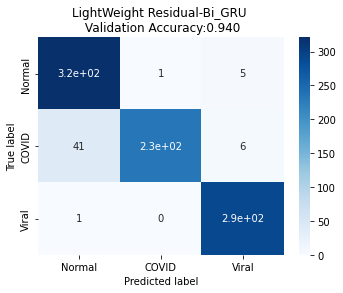

In [ ]:
from sklearn.svm import SVC
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support


# Creates a confusion matrix
cm_v = confusion_matrix(actual, preds) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm_v,
                     index = ['Normal','COVID', 'Viral'], 
                     columns = ['Normal','COVID', 'Viral'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True, cmap='Blues')
plt.title('LightWeight Residual-Bi_GRU \n Validation Accuracy:{0:.3f}'.format(accuracy_score(actual, preds)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(actual,preds))

              precision    recall  f1-score   support

           0       0.88      0.98      0.93       327
           1       1.00      0.83      0.91       280
           2       0.96      1.00      0.98       293

    accuracy                           0.94       900
   macro avg       0.95      0.94      0.94       900
weighted avg       0.94      0.94      0.94       900

